In [1]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt 

#### Load merged events 

In [2]:
events = pd.read_csv("merged_events_case_study_1.csv")

In [3]:
events.head(2)

,event_ID,event_type,source,start_time,end_time,duration,rate,quantity,duration_simulation
0,Event-01,RE,Compressor-2,2024-01-10 07:30:00,2024-03-18 09:15:00,1633.750000,1.835673,2999.031431,False
1,Event-02,RE,Compressor-3,2024-01-08 09:35:00,2024-02-29 17:25:00,1255.833333,1.208226,1517.330272,False


In [4]:
duration_simulation_events = events[events["duration_simulation"] == True]

In [5]:
duration_simulation_events 

,event_ID,event_type,source,start_time,end_time,duration,rate,quantity,duration_simulation
2,Event-03,PRE,A,2024-04-01 16:14:00,2024-04-30 23:59:00,703.75,38.5,27094.375,True


In [6]:
LPR = 0.006 # leak production rate (unit is per site per day)
operator_bonus = 0.5 
Q_max = events.rate.max()
median_sim_duration = [] 
percentile_95_confidence_upper = []
percentile_95_confidence_lower = []
for index,row in duration_simulation_events.iterrows():
    # simulation start time 
    start_time = datetime.strptime(row.start_time,'%Y-%m-%d %H:%M:%S')
    # simulation end time
    end_time = datetime.strptime(row.end_time,'%Y-%m-%d %H:%M:%S')
    rate = row.rate
    duration = row.duration 
    # we repeat 10000 interations for study 
    mc = 0
    mc_total = 10000
    simulated_duration_dist = [] 
    while mc < mc_total:
        # when to stop the simulation  
        sim_end_time = end_time 
        # When to start the simulation 
        sim_time = start_time 
        simulated_start = None 
        simulated_end = None 
        while sim_time < sim_end_time: 
            event_generation = False 
            if not event_generation: 
                sample_leak = np.random.binomial(1, LPR, 1)[0]
                if sample_leak == 1: 
                    event_generation = True
                    simulated_start = sim_time
                    sim_time += timedelta(hours =1)
                else: 
                    sim_time += timedelta(hours =1)
            else: 
                # calcualte NRR see Fox et al., 2021 supporting document 
                NRR = ((LPR)*7/1) * (1/10) +  (operator_bonus*rate)/Q_max
                sample_repair = np.random.binomial(1, NRR, 1)[0]
                if sample_repair == 1:
                    simulated_end = sim_time
                    sim_time += timedelta(hours =1)
                    break 
                else: 
                    sim_time += timedelta(hours =1)

        if simulated_start == None and simulated_end == None: 
            sim_duration = duration
        elif simulated_start != None and simulated_end == None:
            sim_duration = (end_time - simulated_start).total_seconds()/3600
        else:
            sim_duration = (simulated_end - simulated_start).total_seconds()/3600
            
        simulated_duration_dist.append(sim_duration)
        mc += 1 
        if mc%1000 == 0:
            print (mc)
        
    median_sim_duration.append(np.median(simulated_duration_dist))
    percentile_95_confidence_upper.append(np.percentile(simulated_duration_dist, q= 97.5))
    percentile_95_confidence_lower.append(np.percentile(simulated_duration_dist, q= 2.5))

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


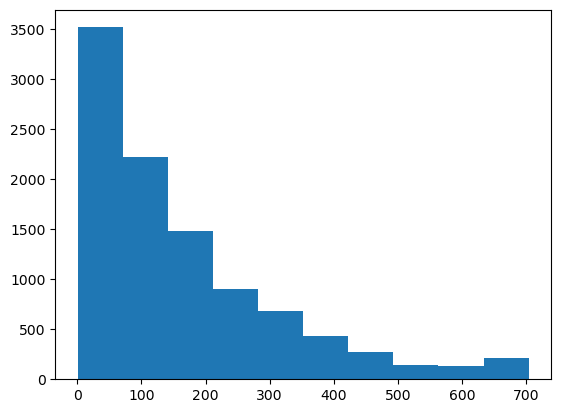

In [7]:
# Simulated duration distribution in above example  
plt.hist(simulated_duration_dist)
plt.show()

In [8]:
median_sim_duration, percentile_95_confidence_upper, percentile_95_confidence_lower

([115.75], [607.75], [4.75])

In [9]:
# median simulated duration is 116.75 hr 
events.at[2, 'duration'] = 116.75 

In [10]:
events.head(3)

,event_ID,event_type,source,start_time,end_time,duration,rate,quantity,duration_simulation
0,Event-01,RE,Compressor-2,2024-01-10 07:30:00,2024-03-18 09:15:00,1633.750000,1.835673,2999.031431,False
1,Event-02,RE,Compressor-3,2024-01-08 09:35:00,2024-02-29 17:25:00,1255.833333,1.208226,1517.330272,False
2,Event-03,PRE,A,2024-04-01 16:14:00,2024-04-30 23:59:00,116.750000,38.500000,27094.375000,True


### Update the rate and duration uncertainty based on simulated results 

As Daniels et al., 2024 indicated in https://doi.org/10.1021/acs.estlett.4c00687, 86.8% of estimates within a factor of 2× error
Thus for PRE that duration is determiend by using CMS observation, we assume the lower uncertainty is 0, and upper uncertainty 2x measured duration in this case study.

For all events, we assume the rate uncertainty is +/- 60% in this case study.

In [11]:
duration_lowers = [] 
duration_uppers = [] 
rate_lowers = [] 
rate_uppers = [] 
for index,row in events.iterrows(): 
    rate_lowers.append(row.rate * 0.6)
    rate_uppers.append(row.rate * 0.6)
    if row.event_type == "RE": 
        duration_lower = 0 
        duration_upper = 0 
    else: 
        if row.duration_simulation == False: 
            duration_lower = 0 
            duration_upper = 2* row.duration
        else: 
            duration_lower = 116.75 - 4.75 
            duration_upper = 606.75 - 116.75
    duration_lowers.append(duration_lower)
    duration_uppers.append(duration_upper)   

In [12]:
events["duration_lower"] = duration_lowers
events["duration_upper"] = duration_uppers
events["rate_lower"] = rate_lowers
events["rate_upper"] = rate_uppers

In [13]:
events.head()

,event_ID,event_type,source,start_time,end_time,duration,rate,quantity,duration_simulation,duration_lower,duration_upper,rate_lower,rate_upper
0,Event-01,RE,Compressor-2,2024-01-10 07:30:00,2024-03-18 09:15:00,1633.750000,1.835673,2999.031431,False,0.0,0.0,1.101404,1.101404
1,Event-02,RE,Compressor-3,2024-01-08 09:35:00,2024-02-29 17:25:00,1255.833333,1.208226,1517.330272,False,0.0,0.0,0.724935,0.724935
2,Event-03,PRE,A,2024-04-01 16:14:00,2024-04-30 23:59:00,116.750000,38.500000,27094.375000,True,112.0,490.0,23.100000,23.100000
3,Event-04,RE,Compressor-3,2024-01-01 04:25:00,2024-01-01 04:35:00,0.166667,1096.777584,182.796264,False,0.0,0.0,658.066550,658.066550
4,Event-05,RE,Tank-1,2024-01-01 13:34:00,2024-01-01 13:40:00,0.100000,2312.586900,231.258690,False,0.0,0.0,1387.552140,1387.552140


In [14]:
events.to_csv("events_with_uncertianty_case_study_1.csv",sep=',', index=False)